In [1]:
!pip install -U accelerate
!pip install -U transformers

In [2]:
import pandas as pd
df = pd.read_csv("./dataset/problems.csv", usecols=["description", "labels"])
df.head()
df['labels'][2]

"['greedy', 'sorting']"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10894 entries, 0 to 10893
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  10894 non-null  object
 1   labels       10894 non-null  object
dtypes: object(2)
memory usage: 170.3+ KB


<Axes: ylabel='Frequency'>

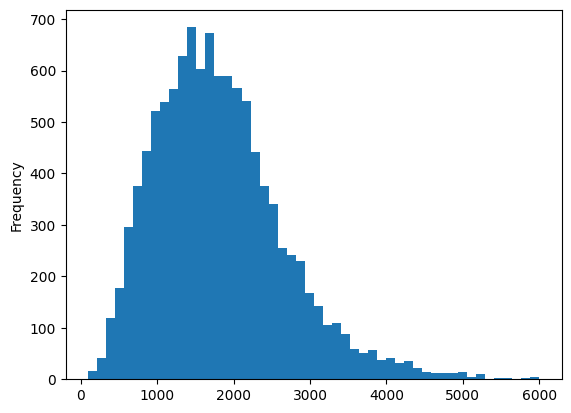

In [3]:
# df.shape
df.info()
# df.duplicated().sum()
df['description'].str.len().plot.hist(bins=50)

In [4]:
import ast

df['labels'] = df['labels'].apply(ast.literal_eval)
labels_cnt = [l for lab in df['labels'] for l in lab]
label_series = pd.Series(labels_cnt).value_counts()
print(label_series)

print("總共有", label_series.index.nunique(), "種 labels")

math                   3550
greedy                 3287
graphs                 3023
data structures        2919
dynamic programming    2618
strings                1512
sorting                1504
binary search          1392
trees                  1043
bit manipulation        825
number theory           818
combinatorics           733
two pointers            729
union find              418
geometry                410
matrices                333
divide and conquer      331
shortest path           279
hashing                 261
game theory             255
probabilities           228
interactive             210
tree                    169
Name: count, dtype: int64
總共有 23 種 labels


In [5]:
from sklearn.preprocessing import MultiLabelBinarizer

multilabel = MultiLabelBinarizer()
labels = multilabel.fit_transform(df["labels"]).astype('float32')  # To align label format with model prediction (both are float)
texts = df["description"].tolist()
# labels
# texts[:5]


In [6]:
import torch
from transformers import DistilBertTokenizer, AutoTokenizer
from transformers import DistilBertForSequenceClassification, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset

/home/mike/cp-problem-classifier/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels,
                                                                    test_size=0.2, random_state=42)

In [8]:
checkpoint = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(checkpoint)
model = DistilBertForSequenceClassification.from_pretrained(checkpoint, num_labels=len(labels[0]),
                                                            problem_type="multi_label_classification")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
labels[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.], dtype=float32)

In [10]:
# Lets build custom dataset
class CustomDataset(Dataset):
  def __init__(self, texts, labels, tokenizer, max_len=128):
    self.texts = texts
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text = str(self.texts[idx])
    label = torch.tensor(self.labels[idx])

    encoding = self.tokenizer(text, truncation=True, padding="max_length", max_length=self.max_len, return_tensors='pt')

    return {
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'labels': label
    }

train_dataset = CustomDataset(train_texts, train_labels, tokenizer)
val_dataset = CustomDataset(val_texts, val_labels, tokenizer)

In [11]:
val_dataset[0]

{'input_ids': tensor([  101,  2023,  2051,  2256,  2775,  2038,  1037,  3722, 26572,  7446,
          1012,  2002,  2038,  2000,  2424,  1996,  2193,  1997,  3971,  2000,
          3975,  1996, 26572,  7446,  2046,  2512,  1011,  2139,  6914, 22139,
         27189,  1010,  2169,  2126,  2442, 13225,  1996,  2206,  5918,  1024,
          1011,  2169, 19449,  1997,  2169,  9546,  2003,  2028,  1997,  1996,
         26572,  7446, 19449,  1025,  1011,  2169,  2217,  1997,  1996, 26572,
          7446,  2442,  2022,  1996,  2217,  1997,  3599,  2028,  9546,  1025,
          1011,  1996,  2181,  1997,  6840,  1997,  2296,  2048, 27189, 19635,
          2000,  5717,  1010,  1998,  1996,  7680,  1997,  2035,  2752,  1997,
         27189, 19635,  2000,  1996,  2181,  1997,  1996, 26572,  7446,  1025,
          1011,  2169,  9546,  2442,  2022,  3294,  2503,  1996, 26572,  7446,
          1025,  1011,  2169,  2217,  1997,  2169,  9546,  2442,  5383,  3599,
          2048, 18984,  1997,  1996, 26

In [12]:
# Multi-Label Classification Evaluation Metrics
import numpy as np
from sklearn.metrics import roc_auc_score, f1_score, hamming_loss
from transformers import EvalPrediction
import torch


def multi_labels_metrics(predictions, labels, threshold=0.3):
  sigmoid = torch.nn.Sigmoid()
  probs = sigmoid(torch.Tensor(predictions))

  y_pred = np.zeros(probs.shape)
  y_pred[np.where(probs>=threshold)] = 1
  y_true = labels

  f1 = f1_score(y_true, y_pred, average = 'macro')
  roc_auc = roc_auc_score(y_true, y_pred, average = 'macro')
  hamming = hamming_loss(y_true, y_pred)

  metrics = {
      "roc_auc": roc_auc,
      "hamming_loss": hamming,
      "f1": f1
  }

  return metrics

def compute_metrics(p:EvalPrediction):
  preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions

  result = multi_labels_metrics(predictions=preds,
                                labels=p.label_ids)

  return result

In [13]:
# Training Arguments
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    output_dir = './results',
    num_train_epochs=5,
    save_steps=1000,
    save_total_limit=2
)

trainer = Trainer(model=model,
                  args=args,
                  train_dataset=train_dataset,
                  eval_dataset = val_dataset,
                  compute_metrics=compute_metrics)

In [14]:
trainer.train()

Step,Training Loss
500,0.286400
1000,0.248100
1500,0.236800
2000,0.224600
2500,0.213600
3000,0.204300
3500,0.196100
4000,0.182000
4500,0.175700
5000,0.161900


TrainOutput(global_step=5450, training_loss=0.20869077769988173, metrics={'train_runtime': 682.7844, 'train_samples_per_second': 63.82, 'train_steps_per_second': 7.982, 'total_flos': 1443607160083200.0, 'train_loss': 0.20869077769988173, 'epoch': 5.0})

In [15]:
trainer.evaluate()

{'eval_loss': 0.2339392602443695,
 'eval_roc_auc': 0.6784007366010261,
 'eval_hamming_loss': 0.09946724664285572,
 'eval_f1': 0.43516475494855295,
 'eval_runtime': 25.5424,
 'eval_samples_per_second': 85.309,
 'eval_steps_per_second': 10.688,
 'epoch': 5.0}

In [16]:
trainer.save_model("distilbert-finetuned-imdb-multi-label")

In [ ]:
# import pickle
# with open("multi-label-binarizer.pkl", "wb") as f:
#   pickle.dump(multilabel, f)

In [ ]:
# from sklearn.metrics import classification_report
# print("Evaluating...")
# preds = trainer.predict(val_dataset).predictions
# pred_binary = (preds > 0.5).astype(int)

# print("\nClassification Report:")
# label_names = multilabel.classes_
# print(classification_report(val_labels, pred_binary, target_names=label_names))


Evaluating...


NameError: name 'trainer' is not defined